In [1]:
# Menginstal package kaggle
!pip install -q kaggle

In [2]:
from google.colab import files

# Mengupload file json dari profile kaggle
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"akbartolandy","key":"5edb1d636bdcb8a16de6dd97ec5d0dee"}'}

In [3]:
# Membuat direktory dan mengubah izin file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [4]:
# Download dataset
!kaggle datasets download -d piyushkumar18/animal-image-classification-dataset

 99% 1.45G/1.47G [00:08<00:00, 219MB/s]
100% 1.47G/1.47G [00:08<00:00, 189MB/s]


In [5]:
import zipfile
local_zip = '/content/animal-image-classification-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [6]:
pip install split_folders

Dataset di bagi pada bagian ini

In [7]:
import os, splitfolders

# Membagi dataset
base_dir = '/content/Animal Image Dataset'
splitfolders.ratio(base_dir, output ='/content/Animal Image Dataset', ratio=(0.8, 0.2)) # Note to reviewer

# Membuat direktori train dan validasi
train_dir = os.path.join('/content/Animal Image Dataset', 'train')
validation_dir = os.path.join('/content/Animal Image Dataset', 'val')

Copying files: 17178 files [00:34, 496.25 files/s]


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Membuat objek ImageDataGenerator untuk data training
train_datagen = ImageDataGenerator(rescale=1./255,
    horizontal_flip=True,
    rotation_range=30,
    zoom_range=0.3,
    shear_range=0.2,
    brightness_range=[0.4,1.5],
    fill_mode = 'nearest',) # validation split

# Membuat objek ImageDataGenerator untuk data testing
test_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
train_generator = train_datagen.flow_from_directory(
        train_dir, # Direktori data latih
        target_size=(150, 200),
        batch_size=32,
        shuffle=True,
        color_mode='rgb',
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir, # Direktori data validasi
        target_size=(150, 200),
        batch_size=32,
        shuffle=True,
        color_mode='rgb',
        class_mode='categorical')

Found 13735 images belonging to 12 classes.
Found 3443 images belonging to 12 classes.


In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.applications import ResNet152V2

# Membuat arsitektur CNN dengan Keras
model = tf.keras.models.Sequential([
    ResNet152V2(weights="imagenet", include_top=False, input_tensor=Input(shape=(150, 200, 3))),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(2, 2),    
    tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(2, 2),    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(12, activation='softmax') 
])
model.layers[0].trainable = False

234553344/234545216 [==============================] - 2s 0us/step


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, 5, 7, 2048)        58331648  
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 7, 256)         4718848   
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 3, 256)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 3, 512)         1180160   
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 1, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               2

In [12]:
# Compile model dengan Adam (loss function 'categorical_crossentropy')
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

filepath_acc='/content/best_acc_weights.h5'
filepath_loss='/content/best_loss_weights.h5'

# Model checkpoint untuk menyimpan best acc/loss model
checkpoint_loss = ModelCheckpoint(filepath_loss, verbose=1, monitor='val_loss', save_best_only=True, mode='min')
checkpoint_acc = ModelCheckpoint(filepath_acc, verbose=1, monitor='val_accuracy', save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', mode='max', factor=0.1, patience=3, min_delta=1e-2, verbose=1)

# Membuat custom callbacks
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.92 and logs.get('val_accuracy') > 0.92):
      print('\nCongratulation accuracy has reach beyond 92%')
      self.model.stop_training = True

callbacks_list = [checkpoint_loss, checkpoint_acc,
                  early_stopping, reduce_lr, myCallback()]

In [14]:
hist = model.fit(
            train_generator, epochs=100, steps_per_epoch=128,
            validation_data=validation_generator, validation_steps=20,
            verbose=1, callbacks=callbacks_list)

Epoch 1/100
128/128 [==============================] - 112s 574ms/step - loss: 0.7094 - accuracy: 0.7915 - val_loss: 0.3587 - val_accuracy: 0.8984

Epoch 00001: val_loss improved from inf to 0.35874, saving model to /content/best_loss_weights.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)



Epoch 00001: val_accuracy improved from -inf to 0.89844, saving model to /content/best_acc_weights.h5
Epoch 2/100
128/128 [==============================] - 68s 534ms/step - loss: 0.4510 - accuracy: 0.8586 - val_loss: 0.2517 - val_accuracy: 0.9172

Epoch 00002: val_loss improved from 0.35874 to 0.25166, saving model to /content/best_loss_weights.h5

Epoch 00002: val_accuracy improved from 0.89844 to 0.91719, saving model to /content/best_acc_weights.h5
Epoch 3/100
128/128 [==============================] - 68s 528ms/step - loss: 0.3919 - accuracy: 0.8774 - val_loss: 0.2442 - val_accuracy: 0.9266

Epoch 00003: val_loss improved from 0.25166 to 0.24422, saving model to /content/best_loss_weights.h5

Epoch 00003: val_accuracy improved from 0.91719 to 0.92656, saving model to /content/best_acc_weights.h5
Epoch 4/100
128/128 [==============================] - 70s 549ms/step - loss: 0.3381 - accuracy: 0.8918 - val_loss: 0.2590 - val_accuracy: 0.9266

Epoch 00004: val_loss did not improve fr

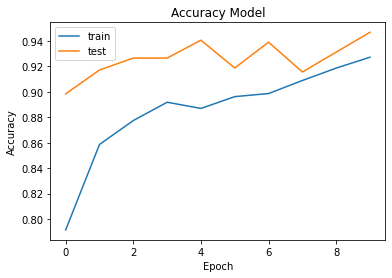

In [17]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Accuracy Model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

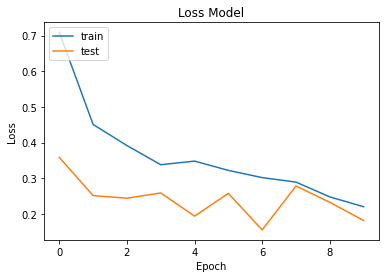

In [18]:
# Plot Loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tmp/tmpn43000ok/assets
